In [1266]:

from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from jones_matrix import JonesMatrix as jm
from jones_matrix import Phases as ph
# change the following to %matplotlib notebook for interactive plotting

In [1267]:
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import numba as nb
import pims
import trackpy as tp
import matplotlib.animation as animation

This is a markdown cell. You can change the cell type in the menu `cell->cell type`.
You can read more about [markdown](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Working%20With%20Markdown%20Cells.html) too.

The cell below defines the director field on a radial droplet the function `f` adds a twist from ref: Liquid Crystals, 1999, Vol. 26, No. 5, 753-758.

$$ f(r) = \frac{1}{\sqrt{r}}\sin\left(\pi\frac{ln(r/r_{min})}{ln(r_{max}/r_{min}}\right) $$


with:

$r$ the radial position in the drop

$r_{max}$ the radius of the drop

$r_{min}$ the radius of the small inclusion contained in the drop

For a point of coordinates (x,y,z), the spherical coordinates are given by

$ r = \sqrt{x^{2}+y^{2}+z^{2}} $

$ \theta = \cos^{-1}\left(\frac{z}{\sqrt{x^{2}+y^{2}+z^{2}}}\right) $

$ \phi = \tan^{-1}\left(\frac{y}{x}\right) $

At this point, the director is defined by the polar coordinates

$n_r = \left(1-0.5\times b^{2}\times f(r)^{2} \right) \times r $

$n_{\phi} = \phi + b \times f(r) = \gamma$

$n_{\theta} = \theta = \beta $

with b being the 'twist amplitude'




In [1268]:
def f(r,rmin,rmax):
    return 1/np.sqrt(r)*np.sin(np.pi*np.log(r/rmin)/np.log(rmax/rmin))

def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan2(y,x)

def nr(x,y,z,b,rmin,rmax):
    return (1-0.5*(b**2)*(f(rd(x,y,z),rmin,rmax)**2))*rd(x,y,z)

def nphi(x,y,z,b,rmin,rmax):
    return b*f(rd(x,y,z),rmin,rmax)+phi(x,y,z)

def ntet(x,y,z):
    return tet(x,y,z)

#def nx(x,y,z,b,rmin,rmax):
#    return nr(x,y,z,b,rmin,rmax)*np.sin(ntet(x,y,z))*np.cos(nphi(x,y,z,b,rmin,rmax))

#def ny(x,y,z,b,rmin,rmax):
#    return nr(x,y,z,b,rmin,rmax)*np.sin(ntet(x,y,z))*np.sin(nphi(x,y,z,b,rmin,rmax))

#def nz(x,y,z,b,rmin,rmax):
#    return nr(x,y,z,b,rmin,rmax)*np.cos(ntet(x,y,z))

#def beta(x,y,z,b,rmin,rmax):
#    return np.arccos(nz(x,y,z,b,rmin,rmax)/np.sqrt((nx(x,y,z,b,rmin,rmax))**2+(ny(x,y,z,b,rmin,rmax))**2+(nz(x,y,z,b,rmin,rmax))**2))

#def gamma(x,y,z,b,rmin,rmax):
#    return np.arctan(ny(x,y,z,b,rmin,rmax)/nx(x,y,z,b,rmin,rmax))

In [141]:
def polarizer(ang):
    return np.array([[np.cos(ang)**2,np.cos(ang)*np.sin(ang)],
                     [np.cos(ang)*np.sin(ang),np.sin(ang)**2]],
                    dtype=np.complex)

Second "empiric" possibility for the definition of a twist:

$$ tw(r) = \frac{a}{r_{max}} \times \left(r_{max}-r\right) $$

In [143]:
def tw(r,rmax,a):
    return (a/rmax)*(rmax-r)

def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan(y/x)


def nr2(x,y,z):
    return rd(x,y,z)

def nphi2(x,y,z,a,rmax):
    return phi(x,y,z)+tw(rd(x,y,z),rmax,a)

def ntet2(x,y,z):
    return tet(x,y,z)

#def nx2(x,y,z,a,rmax):
#    return nr2(x,y,z)*np.sin(ntet2(x,y,z))*np.cos(nphi2(x,y,z,a,rmax))

#def ny2(x,y,z,a,rmax):
#    return nr2(x,y,z)*np.sin(ntet(x,y,z))*np.sin(nphi2(x,y,z,a,rmax))

#def nz2(x,y,z):
#    return nr2(x,y,z)*np.cos(ntet2(x,y,z))

#def beta2(x,y,z,a,rmax):
#    return np.arccos(nz2(x,y,z)/np.sqrt((nx2(x,y,z,a,rmax))**2+(ny2(x,y,z,a,rmax))**2+(nz2(x,y,z))**2))

#def gamma2(x,y,z,a,rmax):
#    return np.arctan(ny2(x,y,z,a,rmax)/nx2(x,y,z,a,rmax))

New definition of the $\beta$ and $\gamma$ angles taken from ref: PRA, Vol 46, 6535 (1992) (eq 5):

$\beta = \theta e^{{-\frac{r_{max}-r}{\xi_{1}}}} + \left(\theta + \left(\frac{\pi}{2}-\theta\right)\left(1-e^{-\frac{x^{2}+y^{2}}{\xi_{2}}}\right)\right) \times \left(1-e^{-\frac{r_{max}-r}{\xi_{1}}}\right)$

$\gamma = \phi + \gamma_{0} e^{\frac{r}{\xi_{3}}} \times \left(1-e^{-\frac{r_{max}-r}{\xi_{1}}}\right)$

The variation in $\beta$ are considered in the paper for applying an electric field and can be negelcted in our case when we consider only an azimuthal twist and we then approximate:

$\beta = \theta$

After calculation of $\beta$ and $\gamma$ we can the obtain the phase shift ($\delta$) and the effectice extraordinary refractive index ($n_{e,eff}$):

$\frac{1}{n_{e,eff}^{2}} = \frac{sin^{2}\beta}{n_{e}^{2}}+\frac{cos^{2}\beta}{n_{o}^{2}}$

$\delta = 2\pi h \frac{n_{e,eff}-n_{o}}{\lambda}$

with h the thickness of the slice of the drop scanned and lambda the wavelentgh of the light, both in the same units.

We can then obtain the Mueller matrice, using the following reference: Thin Solid Films 455–456 (2004) 591–595: 

$ M = \begin{bmatrix}
    1       & 0 & 0 & 0 \\
    0      & cos^{2}(2\gamma)+cos(\delta)sin^{2}(2\gamma) & (1-cos(\delta))sin(2\gamma)cos(2\gamma) & sin(\delta)sin(2\gamma) \\
    0      & (1-cos(\delta))sin(2\gamma)cos(2\gamma) & sin^{2}(2\gamma)+cos(\delta)cos^{2}(2\gamma)  & -sin(\delta)cos(2\gamma) \\
    0       & -sin(\delta)sin(2\gamma) & sin(\delta)cos(2\gamma) & cos(\delta)
\end{bmatrix}$

The polarizers are defined by the following matrices:

$P(\theta) = \frac{1}{2} $

$\begin{bmatrix}
    1       & cos(2\theta) & sin(2\theta) & 0 \\
    cos(2\theta)      & cos^{2}(2\theta) & sin(2\theta)cos(2\theta) & 0 \\
    sin(2\theta)      & sin(2\theta)cos(2\theta) & sin^{2}(2\theta)  & 0 \\
    0       & 0 & 0 & 0
\end{bmatrix}$

The intensity is then obtained by using Stokes vectors and an initial vector of:

$S_{0} = \begin{bmatrix}
    1      \\
    0      \\
    0       \\
    0      
\end{bmatrix}$

In [1791]:
def rd(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

def tet(x,y,z):
    return np.arccos(z/np.sqrt(x**2+y**2+z**2))

def phi(x,y,z):
    return np.arctan2(y,x)

def delta(n_ext_eff,n_ord,wavel,h):
    return 2*np.pi*(n_ext_eff-n_ord)*h/wavel

def n_Extra_Beta(ordinary_n,extraordinary_n,beta):
    _nExtraBeta_num = ordinary_n*extraordinary_n
    _nExtraBeta = (_nExtraBeta_num /
                   (np.sqrt((np.sin(beta)*ordinary_n)**2 +
                     (np.cos(beta)*extraordinary_n)**2)))
    return _nExtraBeta

def mueller(gamma,delta):
    mat1 = (np.cos(2*gamma))**2+((np.sin(2*gamma))**2)*np.cos(delta)
    mat2 = np.cos(2*gamma)*np.sin(2*gamma)*(1-np.cos(delta))
    mat3 = np.sin(2*gamma)*np.sin(delta)
    mat4 = np.cos(2*gamma)*np.sin(delta)
    mat5 = (np.sin(2*gamma))**2+((np.cos(2*gamma))**2)*np.cos(delta)
    mat = np.array(((1,0,0,0),(0,mat1,mat2,mat3),(0,mat2,mat5,-mat4),(0,-mat3,mat4,np.cos(delta))))
    return mat

def beta3(x,y,z):
    return tet(x,y,z)

def gamma3(x,y,z,eps1,eps3,rmax,g0):
    return phi(x,y,z)+g0*np.exp(-rd(x,y,z)/eps3)*(1-np.exp(-(rmax-rd(x,y,z))/eps1))

In [1786]:
def polmuel(ang):
    M = np.array(((1,0,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0)))
    M[0,1] = np.cos(2*ang)
    M[0,2] = np.sin(2*ang)
    M[1,0] = np.cos(2*ang)
    M[1,1] = (np.cos(2*ang))**2
    M[1,2] = np.sin(2*ang)*np.cos(2*ang)
    M[2,0] = np.sin(2*ang)
    M[2,1] = np.sin(2*ang)*np.cos(2*ang)
    M[2,2] = (np.sin(2*ang))**2
    return 0.5*M

In [1795]:
rmax = 5.0 #microns
rmin = rmax/50
n_ord = 1.55
n_ext = 1.70
lamb = 0.550 #microns
zres = 0.0011
xres = 0.011
yres = xres
#wlen = lamb
b = 0
a = 0
eps1 = 0.001
eps2 = 100
eps3 = 0.04
g0 = 0/180*np.pi

In [1796]:
x = np.arange(-1,1,xres)
y = np.arange(-1,1,yres)
z = np.arange(-1,1,zres)

In [1739]:
def jm_mat(x,y,z,b,rmin,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    res_jm[:,:] = np.identity(2,dtype=np.complex)
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < 1:
                    gam = nphi(xi,yi,zi,b,rmin,rmax)
                    bet = ntet(xi,yi,zi)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen,zres)
                    phior = ph.compute_phiord(n_ord,wlen,zres)
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [592]:
def jm_mat2(x,y,z,a,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    #res_jm = np.ones((x.shape[0],2,2),dtype=np.complex)
    #res_jm[:,0,1] = 0
    #res_jm[:,1,0] = 0
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            res_jm[i,j] = np.identity(2,dtype=np.complex)
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = nphi2(xi,yi,zi,a,rmax)
                    bet = ntet2(xi,yi,zi)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen,zres)
                    phior = ph.compute_phiord(n_ord,wlen,zres)
                    #res_jm[i] = np.dot(res_jm[i],
                    #                   jm.jones_matrix(gam,phiex,phior))
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [1070]:
def jm_mat3(x,y,z,eps1,eps2,eps3,rmax,g0,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    res_jm[:,:] = np.identity(2,dtype=np.complex)
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = gamma3(xi,yi,zi,eps1,eps3,rmax,g0)
                    bet = beta3(xi,yi,zi,eps1,eps2,rmax)
                    phiex = ph.compute_phiex(bet,n_ord,n_ext,wlen*rmax,zres)
                    phior = ph.compute_phiord(n_ord,wlen*rmax,zres)
                    res_jm[i,j] = np.dot(jm.jones_matrix(gam,phiex,phior),
                                   res_jm[i,j])
    return res_jm

In [842]:
def jm_mat4(x,y,z,b,rmin,rmax,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],2,2),dtype=np.complex)
    phiex = 0
    phior = 0
    #res_jm = np.ones((x.shape[0],2,2),dtype=np.complex)
    #res_jm[:,0,1] = 0
    #res_jm[:,1,0] = 0
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            res_jm[i,j] = np.identity(2,dtype=np.complex)
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                    gam = nphi(xi,yi,zi,b,rmin,rmax)
                    bet = ntet(xi,yi,zi)
                    for wleni in wlen:
                        mat = np.identity(2,dtype=np.complex)
                        phiex = ph.compute_phiex(bet,n_ord,n_ext,wleni,zres)
                        phior = ph.compute_phiord(n_ord,wleni,zres)
                        mat = np.dot(mat,jm.jones_matrix(gam,phiex,phior))
                    res_jm[i,j] = np.dot(mat,res_jm[i,j])
    return res_jm

In [1026]:
def jm_mat5(x,y,z,eps1,eps2,eps3,rmax,g0,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],wlen.shape[0],2,2),dtype=np.complex)
    res_jm[:,:,:] = np.identity(2,dtype=np.complex)
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            for k,wleni in enumerate(wlen):
                for zi in z:
                    if np.sqrt(xi**2+yi**2+zi**2) < rmax:
                        gam = gamma3(xi,yi,zi,eps1,eps3,rmax,g0)
                        bet = beta3(xi,yi,zi,eps1,eps2,rmax)                                  
                        phiex = ph.compute_phiex(bet,n_ord,n_ext,wleni,zres)
                        phior = ph.compute_phiord(n_ord,wleni,zres)
                        res_jm[i,j,k] = np.dot(jm.jones_matrix(gam,phiex,phior),res_jm[i,j,k])
    im = np.zeros((x.shape[0],y.shape[0]))
    #E = np.array([[1],[1]],dtype=np.complex)
    pol = polarizer(0)
    an = polarizer(np.pi/2)
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            Et = np.array([[0,0],[0,0]],dtype=np.complex)
            for k in np.arange(wlen.shape[0]):
                Et = Et+np.dot(an,np.dot(res_jm[i,j,k],pol))
            Ex = Et[0][0]
            Ey = Et[1][0]
            Int = Ex*np.conj(Ex)+Ey*np.conj(Ey)
            im[i,j] = np.real(Int)                
    return res_jm,im

In [1790]:
def jm_mat6(x,y,z,eps1,eps2,eps3,rmax,g0,wlen):
    res_jm = np.ones((x.shape[0],y.shape[0],4,4))
    res_jm[:,:] = np.identity(4)
    for i,xi in enumerate(x):
        for j,yi in enumerate(y):
            for zi in z:
                if np.sqrt(xi**2+yi**2+zi**2) < 1:
                    gam = gamma3(xi,yi,zi,eps1,eps3,rmax,g0)
                    bet = beta3(xi,yi,zi)
                    nExtraEff = n_Extra_Beta(n_ord,n_ext,bet)
                    delt = delta(nExtraEff,n_ord,wlen,zres*rmax)
                    res_jm[i,j] = np.dot(res_jm[i,j],mueller(gam,delt))
    S_0 = np.array(([1],[0],[0],[0]))
    pol = polmuel(0)
    an = polmuel(np.pi/2)
    im = np.zeros((x.shape[0],y.shape[0]))
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            S = np.dot(pol,np.dot(res_jm[i,j],np.dot(an,S_0)))
            im[i,j] = S[0][0]
    return res_jm,im

In [1742]:
jms = jm_mat(x,y,z,b,rmin,rmax,0.660)

In [654]:
jms2 = jm_mat2(x,y,z,a,rmax,0.660)

In [1092]:
jms3 = jm_mat3(x,y,z,eps1,eps2,eps3,rmax,g0,0.660)

In [232]:
def jmim(jms):
    im = np.zeros((x.shape[0],y.shape[0]))
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            im[i,j] = np.linalg.norm(np.dot(np.dot(polarizer(0),jms[i,j]),
                                      polarizer(np.pi/2)))
    return im

In [566]:
def jmim2(jms):
    im = np.zeros((x.shape[0],y.shape[0]))
    #E = np.array([[1],[1]],dtype=np.complex)
    pol = polarizer(0)
    an = polarizer(np.pi/2)
    for i in np.arange(x.shape[0]):
        for j in np.arange(y.shape[0]):
            Exy = np.dot(an,np.dot(jms[i,j],pol))
            Ex = Exy[0][0]
            Ey = Exy[1][0]
            Int = Ex*np.conj(Ex)+Ey*np.conj(Ey)
            im[i,j] = np.real(Int)            
    return im

In [567]:
im = np.zeros((x.shape[0],y.shape[0]))
for i in np.arange(x.shape[0]):
    for j in np.arange(y.shape[0]):
        im[i,j] = np.linalg.norm(np.dot(np.dot(polarizer(0),jms[i,j]),
                                      polarizer(np.pi/2)))

In [1743]:
im2 = jmim2(jms)

In [1048]:
wlenres = 0.020
wlenmin = 0.400
wlenmax = 0.801
wleng = np.arange(wlenmin,wlenmax,wlenres)
print(wleng)
wccd = [0.55, 0.6, 0.65, 0.75, 0.9, 1, 1, 1, 0.97, 0.95, 0.92, 0.88, 0.82, 0.78, 0.72, 0.68, 0.62, 0.55, 0.48, 0.44, 0.4]
wlamp = [0.14, 0.2, 0.24, 0.32, 0.37, 0.42, 0.46, 0.51, 0.57, 0.62, 0.66, 0.7, 0.74, 0.78, 0.8, 0.82, 0.84, 0.85, 0.86, 0.87, 0.87]

[ 0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8 ]


In [946]:
imt = np.zeros((x.shape[0],y.shape[0]))
for i,wlengi in enumerate(wleng):
    jms_ = jm_mat3(x,y,z,eps1,eps2,eps3,rmax,g0,wlengi)
    im = jmim2(jms_)
    imt = imt + im

In [843]:
jms4 = jm_mat4(x,y,z,b,rmin,rmax,wleng)

In [1800]:
[jms6,im6] = jm_mat6(x,y,z,eps1,eps2,eps3,20,g0,0.660)

In [1765]:
[jms7,im7] = jm_mat7(x,y,0.01,eps1,eps2,eps3,20,g0,0.660)

In [1755]:
jms_ = jm_mat_(x,y,0.005,b,rmin,rmax,0.660)

In [1757]:
im8 = jmim2(jms_)

In [1094]:
im4 = jmim2(jms3)

In [1020]:
im6 = jmim2(jms5[:,:,0])

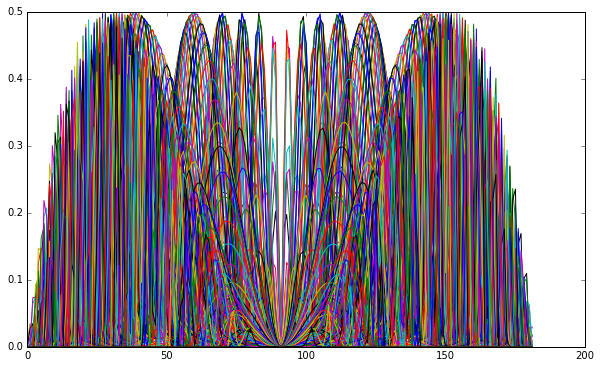

In [1801]:
plt.plot(im6)

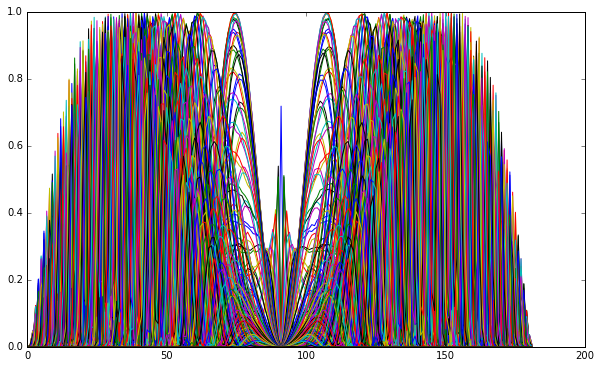

In [1758]:
plt.plot(im8)

(-1.0, 1.0, -1.0, 1.0)

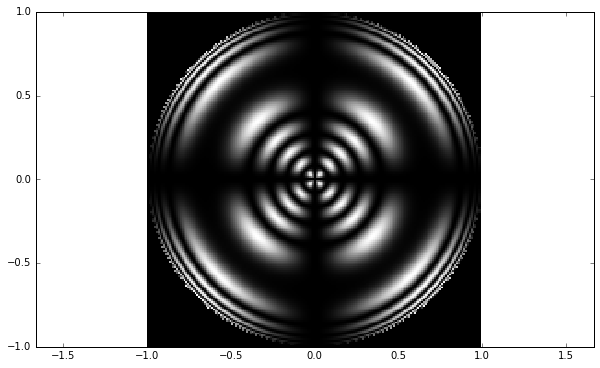

In [1802]:
plt.pcolor(x,y,im6,cmap=plt.cm.gray)
plt.axis('equal')

(-1.0, 1.0, -1.0, 1.0)

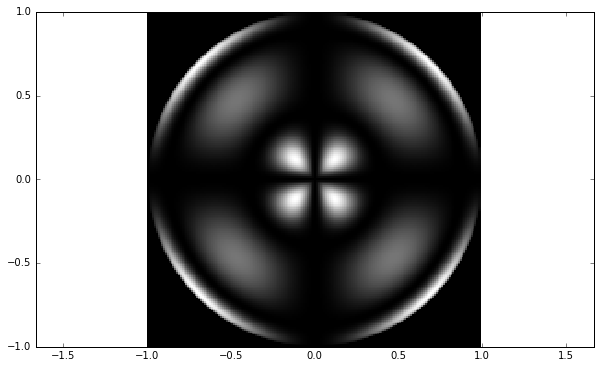

In [1799]:
plt.pcolor(x,y,im6,cmap=plt.cm.gray)
plt.axis('equal')

(-1.0, 1.0, -1.0, 1.0)

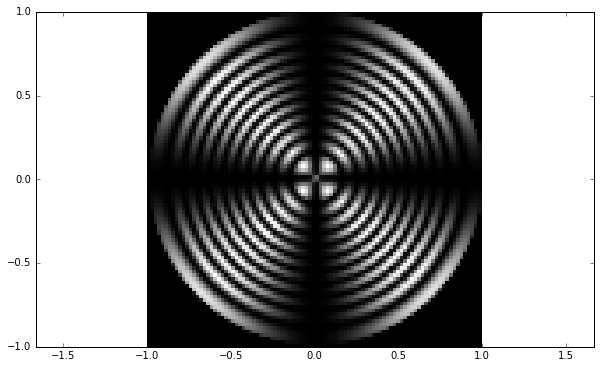

In [1681]:
plt.pcolor(x,y,im2,cmap=plt.cm.gray)
plt.axis('equal')

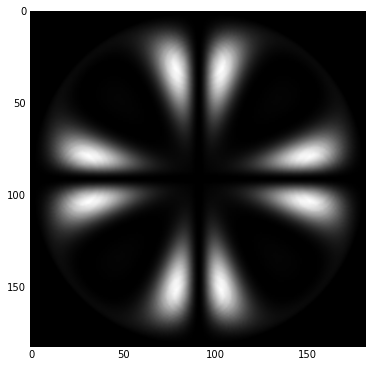

In [1372]:
fig=plt.imshow(im6)

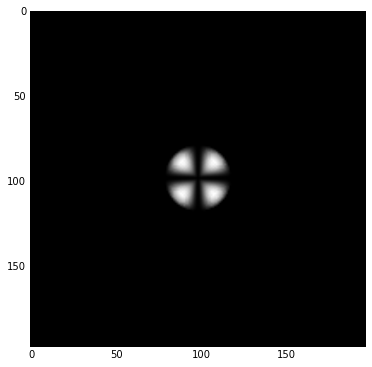

In [1462]:
fig=plt.imshow(im6)